In [1]:
%matplotlib notebook

from Bio.PDB.PDBParser import PDBParser

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection

import numpy as np
import pandas as pd
from scipy.spatial import distance
import math

def average_pos(poss):
    avg_X, avg_Y, avg_Z = zip(*poss)
    avg_X = np.mean(avg_X)
    avg_Y = np.mean(avg_Y)
    avg_Z = np.mean(avg_Z)
    return avg_X, avg_Y, avg_Z

def dot_product(vec1, vec2):
    return sum([float(v1) * float(v2) for v1, v2 in zip(vec1, vec2)])

def vec_len(vec):
    return math.sqrt(float(sum([v * v for v in vec])))

def vec_angle(vec1, vec2):
    if vec1 == vec2:
        return 0.0
    angle = dot_product(vec1, vec2) / (vec_len(vec1) * vec_len(vec2))
    angle = math.degrees(math.acos(angle))
    assert 0.0 <= angle <= 360.0
    return angle
def perpendicular_proj(normal, point_plane, point):
    d = (point-point_plane).dot(normal/np.linalg.norm(normal))
    return point - d * (normal/np.linalg.norm(normal))

def calc_side_chain_vector(protres_name, protres_atoms, suppress_warnings=False):
    # composed of two vectors
    # 1. from average position of 'N', 'C' and 'O' atoms to 'CA'
    # 2. average vector from 'CA' to all other atoms except ('N', 'C' and 'O')

    # 1.
    avg_backbone = []
    CA_atom_coords = []
    avg_side_chain = []
    for a_id, coords in protres_atoms.items():
        if a_id in ['N', 'C', 'O']:
            if a_id != 'O':
                avg_backbone.append(coords)
        elif a_id == 'CA':
            CA_atom_coords.append(coords)
        else:
            if a_id == 'CB':
                avg_side_chain.append(coords)

    if len(CA_atom_coords) != 1:
        if not suppress_warnings:
            print("Warning, no CA atom in:", protres_name)
        return None, None

    assert len(CA_atom_coords) == 1
    CA_atom_coords = CA_atom_coords[0]
    CA_pos_X, CA_pos_Y, CA_pos_Z = CA_atom_coords
    backbone_X, backbone_Y, backbone_Z = average_pos(avg_backbone)

    vec_1 = (
        CA_pos_X - backbone_X, CA_pos_Y - backbone_Y, CA_pos_Z - backbone_Z)

    if protres_name == 'GLY':
        assert len(avg_side_chain) == 0
        return vec_1, CA_atom_coords
    else:
        assert len(avg_side_chain) > 0

    # 2.
    side_X, side_Y, side_Z = average_pos(avg_side_chain)
    vec_2 = (side_X - CA_pos_X, side_Y - CA_pos_Y, side_Z - CA_pos_Z)

    # angle between the two vectors has to be less than 90
    # A . B = |A| * |B| * cos(angle)
    # cos(angle) = A.B / (|A|*|B|)
    # angle = arccos(A.B / (|A|*|B|))
    # angle_deg = vec_angle(vec_1, vec_2)
    #
    # if angle_deg > 180.0:
    #    angle_deg = angle_deg - 360.0
    # if angle_deg >= 70:
    #    if not suppress_warnings:
    #        print("Warning: high angle (%s) between CA-CB and bacbone-CA vectors in %s" % (angle_deg, protres_name))
    #    return None, None
    #
    # assert angle_deg < 70.0

    # average of the two vectors
    vec = tuple(v1 + v2 for v1, v2 in zip(vec_1, vec_2))

    return vec, CA_atom_coords

def get_protein_and_rna(structure):
    protein = []
    protein_names = []
    rna = []
    rna_names = []
    for model in structure:
        for chain in model:
            for residue in chain:
                res_name = residue.get_resname().strip()
                atoms = {}
                for atom in residue:
                    atoms[atom.id] = atom.get_coord()

                if res_name in ['A', 'C', 'G', 'U']:
                    rna.append(atoms)
                    rna_names.append(res_name)
                if (res_name in [ 'ALA', 'ARG','ASN','ASP','CYS','GLU','GLN','HIS','ILE','LEU','LYS','MET',
                                 'PHE','PRO','SER','THR','TRP','TYR', 'VAL']
                        and {'CA', 'CB', 'C', 'N'}.issubset(set(atoms.keys()))) or \
                        (res_name == 'GLY' and {'CA', 'C', 'N'}.issubset(set(atoms.keys()))):

                    protein.append(atoms)
                    protein_names.append(res_name)
    return protein, rna, protein_names, rna_names

def bounding_box(atoms):
    positive = atoms[np.where(atoms[:, 2] >= 0)[0], :3]
    negative = atoms[np.where(atoms[:, 2] < 0)[0], :3]


    all_max = np.amax(atoms, axis=0)[:3]
    all_min = np.amin(atoms, axis=0)[:3]

    x_, y_, z_ = np.max(np.abs(np.vstack((all_max, all_min,))), axis=0)

    z_pos = np.amax(positive, axis=0)[2]

    if negative.shape[0] != 0:
        z_neg = np.amin(negative, axis=0)[2]
    else:
        z_neg = 0

    points = np.array([[-x_, -y_, z_neg],
                       [x_, -y_, z_neg],
                       [x_, y_, z_neg],
                       [-x_, y_, z_neg],
                       [-x_, -y_, z_pos],
                       [x_, -y_, z_pos],
                       [x_, y_, z_pos],
                       [-x_, y_, z_pos]])

    return (x_, y_, z_pos, z_neg), points

def transformation_matrix(aminoacid_atoms, aminoacid_name):
    a = aminoacid_atoms['CA']
    b = np.array(calc_side_chain_vector(aminoacid_name, aminoacid_atoms, suppress_warnings=False)[0])
    # b = aminoacid_atoms['CB']
    c1 = aminoacid_atoms['C']
    c2 = aminoacid_atoms['N']
    if (b - a).dot(c2 - c1) == 0:
        c = a + (c2 - c1)
    else:
        c1_p = perpendicular_proj(b - a, a, c1)
        c2_p = perpendicular_proj(b - a, a, c2)
        #print((c1_p - c2_p).dot(b - a))
        c = a + (c2_p - c1_p)

    d = a + np.cross((b - a), (c - a))

    u = ((d - a) / (np.linalg.norm(d - a)))
    v = ((c - a) / np.linalg.norm(c - a))
    w = ((b - a) / np.linalg.norm(b - a))
    u_m = np.append(u, 0)
    v_m = np.append(v, 0)
    w_m = np.append(w, 0)

    m = np.vstack((u_m, v_m, w_m, np.array([0, 0, 0, 1])))
    a_t = m.dot(np.append(a, 1))
    m[:, 3] = -a_t

    m2 = np.column_stack((u_m, v_m, w_m, np.array([0, 0, 0, 1])))
    m2[:, 3] = np.append(a, 1)

    #angle between b and c1->c2
    angle = (np.arccos((b.dot(c2-c1))/(np.linalg.norm(b) * np.linalg.norm(c2-c1)))) * (180/np.pi)

    return m, m2, angle

def plot_transformation(structure_id, amino_acid, z_aprox, num_figures=5):
    j = 0
    parser = PDBParser()
    structure = parser.get_structure(structure_id, 'pdb structures/' + 'pdb' + structure_id + '.ent')

    protein, rna, protein_names, rna_names = get_protein_and_rna(structure)

    for aminoacid_atoms, aminoacid_name in zip(protein, protein_names):
        if j >= num_figures:
            break
            
        min_dist = 1000
        closest = -1
        for i, rna_atoms in enumerate(rna):
            dist = np.min(distance.cdist(np.array(list(aminoacid_atoms.values())), np.array(list(rna_atoms.values()))))
            if dist < min_dist:
                min_dist = dist
                closest = i

        #transformation matrix
        a = aminoacid_atoms['CA']
        b = np.array(calc_side_chain_vector(aminoacid_name, aminoacid_atoms, suppress_warnings=False)[0])
        # b = aminoacid_atoms['CB']
        c1 = aminoacid_atoms['C']
        c2 = aminoacid_atoms['N']
        if (b - a).dot(c2 - c1) == 0:
            c = a + (c2 - c1)
        else:
            c1_p = perpendicular_proj(b - a, a, c1)
            c2_p = perpendicular_proj(b - a, a, c2)
            # print((c1_p - c2_p).dot(b - a))
            c = a + (c2_p - c1_p)

        d = np.cross((b - a), (c - a))

        u = (d / (np.linalg.norm(d)))
        v = ((c - a) / np.linalg.norm(c - a))
        w = ((b - a) / np.linalg.norm(b - a))
        u_m = np.append(u, 0)
        v_m = np.append(v, 0)
        w_m = np.append(w, 0)

        m = np.vstack((u_m, v_m, w_m, np.array([0, 0, 0, 1])))
        a_t = m.dot(np.append(a, 1))
        m[:, 3] = -a_t

        m2 = np.column_stack((u_m, v_m, w_m, np.array([0, 0, 0, 1])))
        m2[:, 3] = np.append(a, 1)
        
        angle = (np.arccos((b.dot(c2-c1))/(np.linalg.norm(b) * np.linalg.norm(c2-c1)))) * (180/np.pi)

        t = np.array(list(aminoacid_atoms.values()))
        t_names = list(aminoacid_atoms)
        t_1 = np.hstack((t, np.ones((t.shape[0], 1))))
        tn = np.round(m.dot(t_1.T).T, 5)[:,:3]


        t_rna = np.array(list(rna[closest].values()))
        t_rna_1 = np.hstack((t_rna, np.ones((t_rna.shape[0], 1))))
        tn_rna = np.round(m.dot(t_rna_1.T).T, 5)[:,:3]

        (x_, y_, z_pos, z_neg), tocke = bounding_box(tn[:, :3])

        x, y, z = 2* x_, 2*y_, z_pos - z_neg

        if (aminoacid_name == amino_acid) and (z_aprox - 0.1< z < z_aprox + 0.1) and (j < num_figures):
            j +=1

            print('sizes(x, y, z): ', x, y, z)
            print('angle: ', angle)

            negative = tn[np.where(tn[:, 2] < 0)[0], :3]
            positive = tn[np.where(tn[:, 2] >= 0)[0], :3]
            rna_above = tn_rna[np.where(tn_rna[:, 2] >= z_pos)[0], :3]
            rna_belove = tn_rna[np.where(tn_rna[:, 2] < z_pos)[0], :3]

            fig = plt.figure(figsize=plt.figaspect(0.5))

            ax = fig.add_subplot(1, 2, 2, projection='3d')
            ax.set_aspect('equal')
            # ax.plot(tn[:, 0], tn[:, 1], tn[:, 2], 'ko')
            ax.plot(positive[:, 0], positive[:, 1], positive[:, 2], 'ko')
            ax.plot(negative[:, 0], negative[:, 1], negative[:, 2], 'go')

            ax.plot(tn_rna[:, 0], tn_rna[:, 1], tn_rna[:, 2], 'mo')

            ca_n = tn[t_names.index('CA'), :3]
            b_n = m.dot(np.append(b, 1))[:3]
            c_n = tn[t_names.index('C'), :3]
            n_n = tn[t_names.index('N'), :3]
            cp_n = m.dot(np.append(c1_p, 1))[:3]
            np_n = m.dot(np.append(c2_p, 1))[:3]

            ax.plot([c_n[0]], [c_n[1]], [c_n[2]], 'ro')
            ax.plot([n_n[0]], [n_n[1]], [n_n[2]], 'bo')

            ax.plot([ca_n[0], b_n[0]], [ca_n[1], b_n[1]], [ca_n[2], b_n[2]])
            ax.plot([cp_n[0], np_n[0]], [cp_n[1], np_n[1]], [cp_n[2], np_n[2]])

            # plot vertices
            ax.scatter3D(tocke[:, 0], tocke[:, 1], tocke[:, 2])

            # list of sides' polygons of figure
            verts = [[tocke[0], tocke[1], tocke[2], tocke[3]],
                     [tocke[4], tocke[5], tocke[6], tocke[7]],
                     [tocke[0], tocke[1], tocke[5], tocke[4]],
                     [tocke[2], tocke[3], tocke[7], tocke[6]],
                     [tocke[1], tocke[2], tocke[6], tocke[5]],
                     [tocke[4], tocke[7], tocke[3], tocke[0]],
                     [tocke[2], tocke[3], tocke[7], tocke[6]]]


            # plot sides
            ax.add_collection3d(
                Poly3DCollection(verts, facecolors='lightcyan', linewidths=1, edgecolors='dodgerblue', alpha=.25))

            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            ax.set_zlabel('Z')

            all = np.concatenate((tn, tn_rna, tocke))
            X = all[:, 0]
            Y = all[:, 1]
            Z = all[:, 2]
            max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max() / 2.0

            mid_x = (X.max()+X.min()) * 0.5
            mid_y = (Y.max()+Y.min()) * 0.5
            mid_z = (Z.max()+Z.min()) * 0.5
            ax.set_xlim(mid_x - max_range, mid_x + max_range)
            ax.set_ylim(mid_y - max_range, mid_y + max_range)
            ax.set_zlim(mid_z - max_range, mid_z + max_range)


            ax = fig.add_subplot(1, 2, 1, projection='3d')
            ax.set_aspect('equal')
            ax.plot(t[:, 0], t[:, 1], t[:, 2], 'ko', label='aminoacid atoms')

            ax.plot(t_rna[:, 0], t_rna[:, 1], t_rna[:, 2], 'mo', label='nucleotid atoms')

            # ca = t[t_names.index('CA'), :3]
            # c = t[t_names.index('C'), :3]
            # n = t[t_names.index('N'), :3]
            ax.plot([c1[0]], [c1[1]], [c1[2]], 'ro', label='C')
            ax.plot([c2[0]], [c2[1]], [c2[2]], 'bo', label='N')

            ax.plot([a[0], b[0]], [a[1], b[1]], [a[2], b[2]])
            ax.plot([c1_p[0], c2_p[0]], [c1_p[1], c2_p[1]], [c1_p[2], c2_p[2]])
    
            tocke_1 = np.hstack((tocke, np.ones((tocke.shape[0], 1))))
            tocke_ = np.round(m2.dot(tocke_1.T).T, 5)[:,:3]

            # list of sides' polygons of figure
            verts_ = [[tocke_[0], tocke_[1], tocke_[2], tocke_[3]],
                      [tocke_[4], tocke_[5], tocke_[6], tocke_[7]],
                      [tocke_[0], tocke_[1], tocke_[5], tocke_[4]],
                      [tocke_[2], tocke_[3], tocke_[7], tocke_[6]],
                      [tocke_[1], tocke_[2], tocke_[6], tocke_[5]],
                      [tocke_[4], tocke_[7], tocke_[3], tocke_[0]],
                      [tocke_[2], tocke_[3], tocke_[7], tocke_[6]]]


            # plot sides
            ax.add_collection3d(
                Poly3DCollection(verts_, facecolors='lightcyan', linewidths=1, edgecolors='dodgerblue', alpha=.25))

            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            ax.set_zlabel('Z')

            all_o = np.concatenate((t, t_rna, tocke_))
            X = all_o[:, 0]
            Y = all_o[:, 1]
            Z= all_o[:, 2]
            # max_range = np.array([X.max() - X.min(), Y.max() - Y.min(), Z.max() - Z.min()]).max() / 2.0

            mid_x = (X.max() + X.min()) * 0.5
            mid_y = (Y.max() + Y.min()) * 0.5
            mid_z = (Z.max() + Z.min()) * 0.5
            ax.set_xlim(mid_x - max_range, mid_x + max_range)
            ax.set_ylim(mid_y - max_range, mid_y + max_range)
            ax.set_zlim(mid_z - max_range, mid_z + max_range)

            fig.suptitle(f"Structure  ID: {structure_id}, Protein: {aminoacid_name}")
            ax.legend(loc='best', fancybox=True, framealpha=0.5)

            plt.show()


sizes(x, y, z):  4.68348 3.58646 2.7813999999999997
angle:  88.18508463822238


<IPython.core.display.Javascript object>


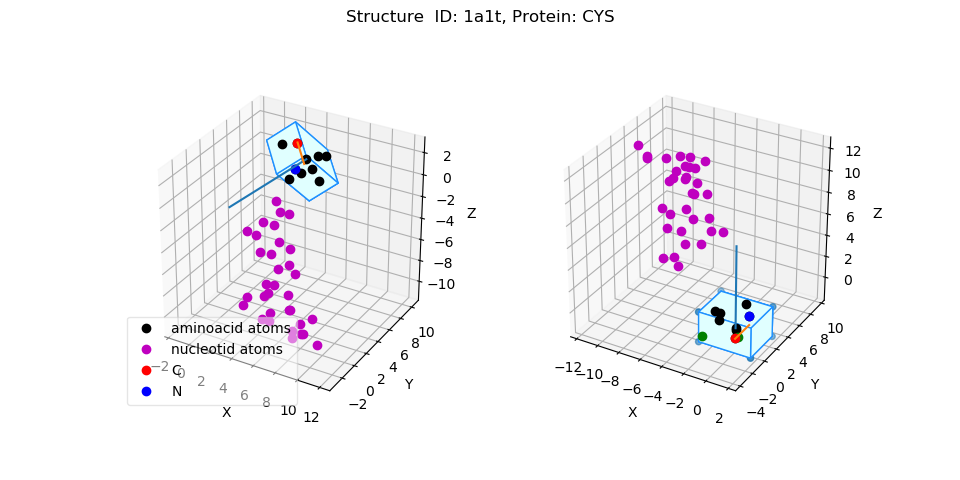

sizes(x, y, z):  5.08864 4.58526 2.77751
angle:  88.20862147010224


<IPython.core.display.Javascript object>


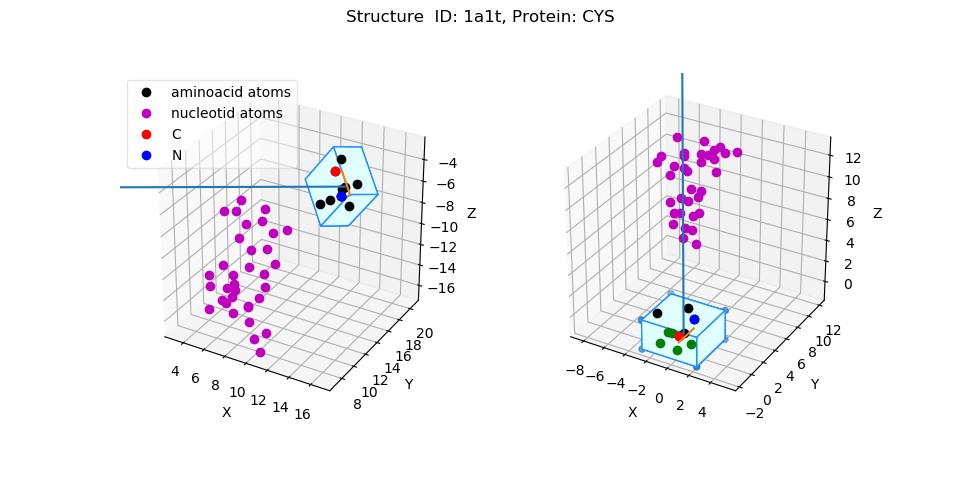

sizes(x, y, z):  5.0716 4.59818 2.7614900000000002
angle:  88.20974162112613


<IPython.core.display.Javascript object>


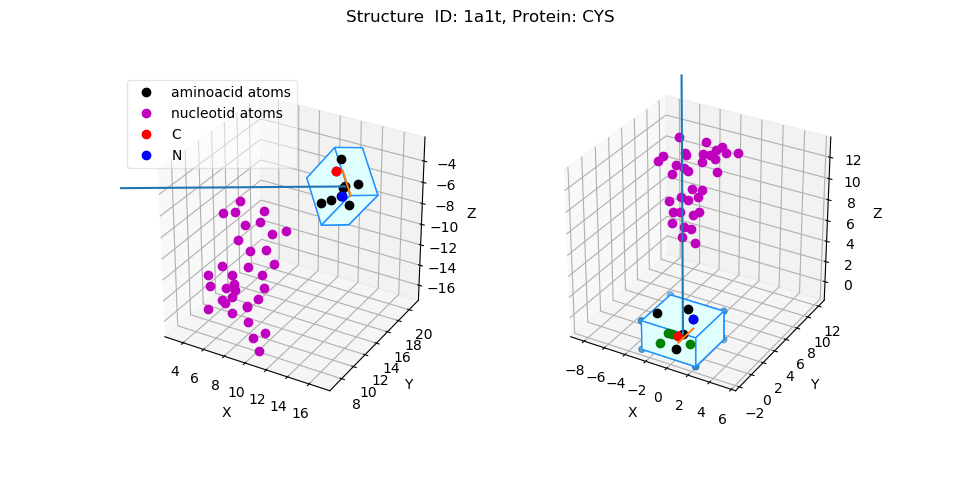

In [2]:
plot_transformation('1a1t', 'CYS', 2.7, 3)

sizes(x, y, z):  4.2435 4.17612 3.6956300000000004
angle:  88.21158577220203


<IPython.core.display.Javascript object>


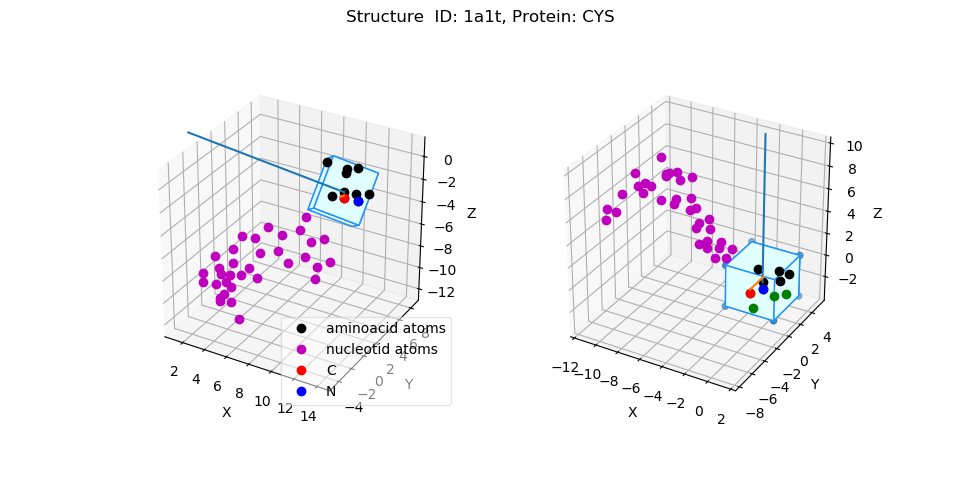

sizes(x, y, z):  4.2311 4.21964 3.71347
angle:  88.2215919993361


<IPython.core.display.Javascript object>


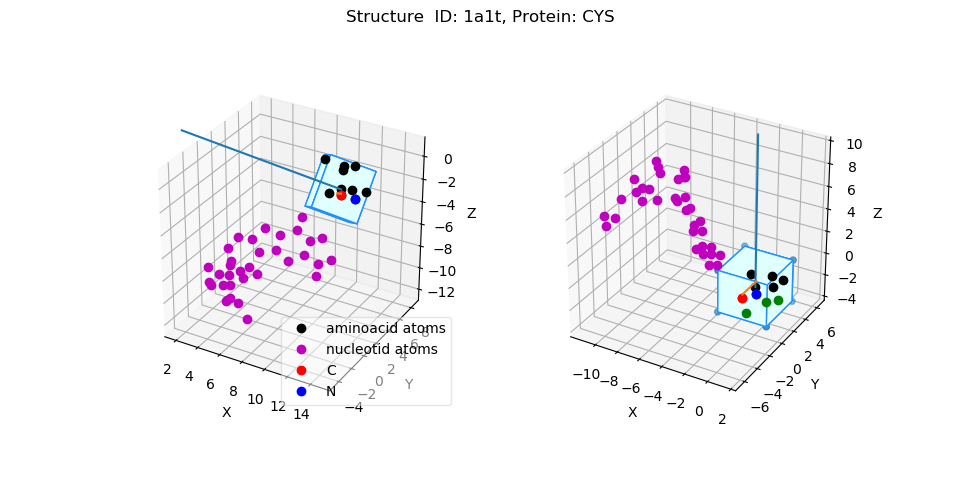

sizes(x, y, z):  4.27516 4.07456 3.6919899999999997
angle:  88.22573792416229


<IPython.core.display.Javascript object>


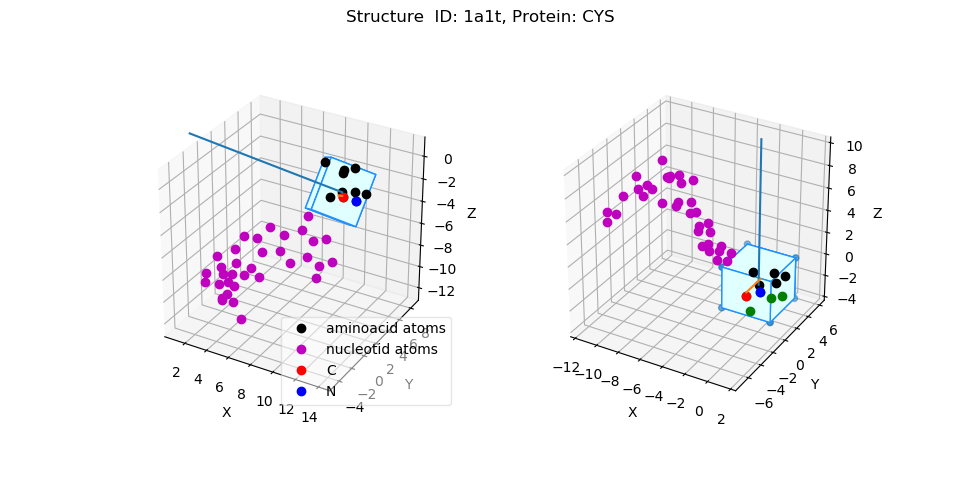

In [3]:
plot_transformation('1a1t', 'CYS', 3.7, 3)

sizes(x, y, z):  11.01812 3.68156 3.7898
angle:  88.28755796634007


<IPython.core.display.Javascript object>


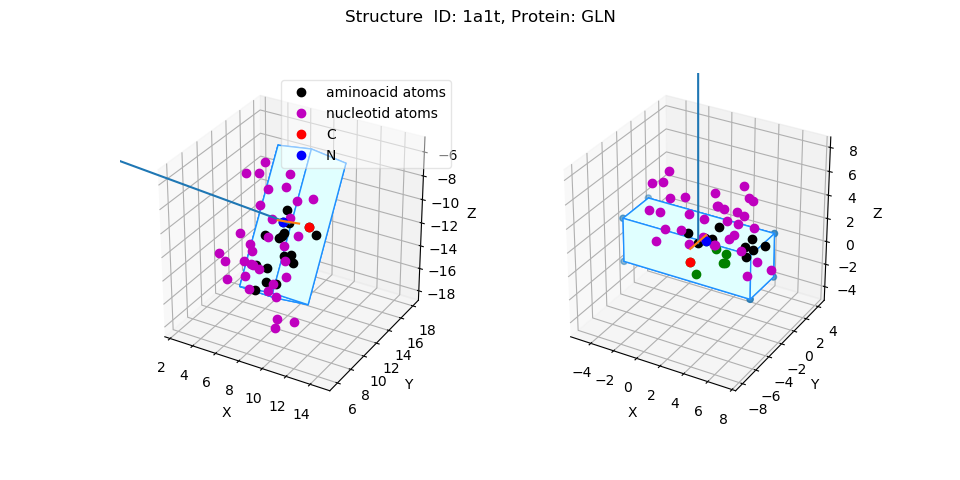

sizes(x, y, z):  9.03296 5.63608 3.6924099999999997
angle:  88.30214042021805


<IPython.core.display.Javascript object>


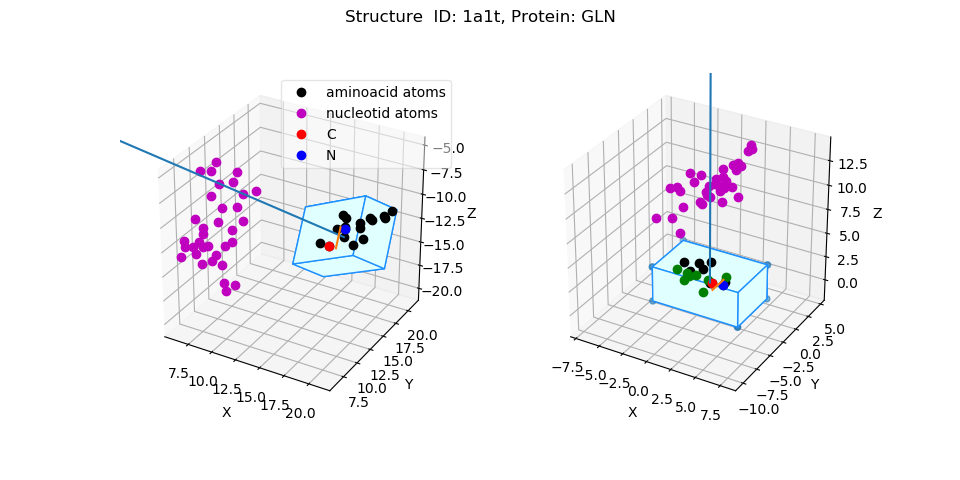

sizes(x, y, z):  7.53614 7.33488 3.6703900000000003
angle:  88.31294577948502


<IPython.core.display.Javascript object>


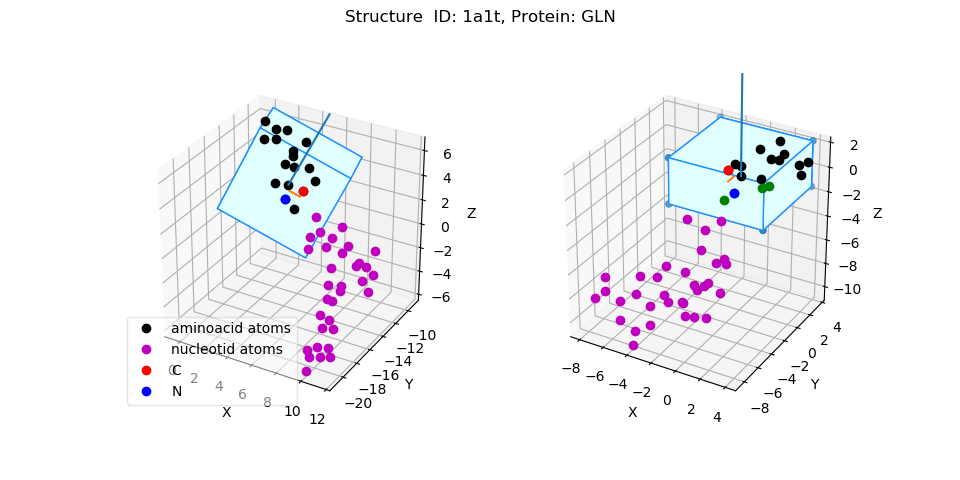

In [4]:
plot_transformation('1a1t', 'GLN', 3.7, 3)

sizes(x, y, z):  7.6919 5.46276 5.45612
angle:  88.34146181926982


<IPython.core.display.Javascript object>


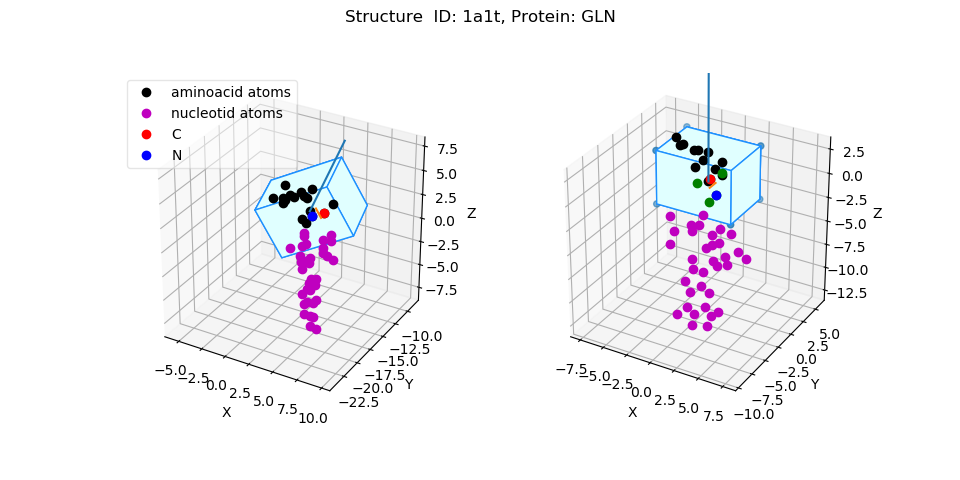

sizes(x, y, z):  5.05618 7.24994 5.47437
angle:  88.32196162918943


<IPython.core.display.Javascript object>


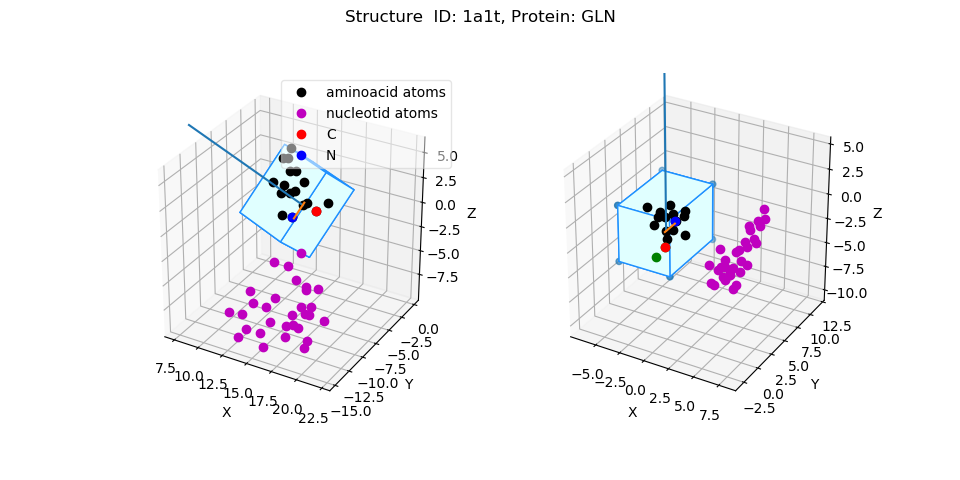

sizes(x, y, z):  4.09584 7.6609 5.4342299999999994
angle:  88.3107191378156


<IPython.core.display.Javascript object>


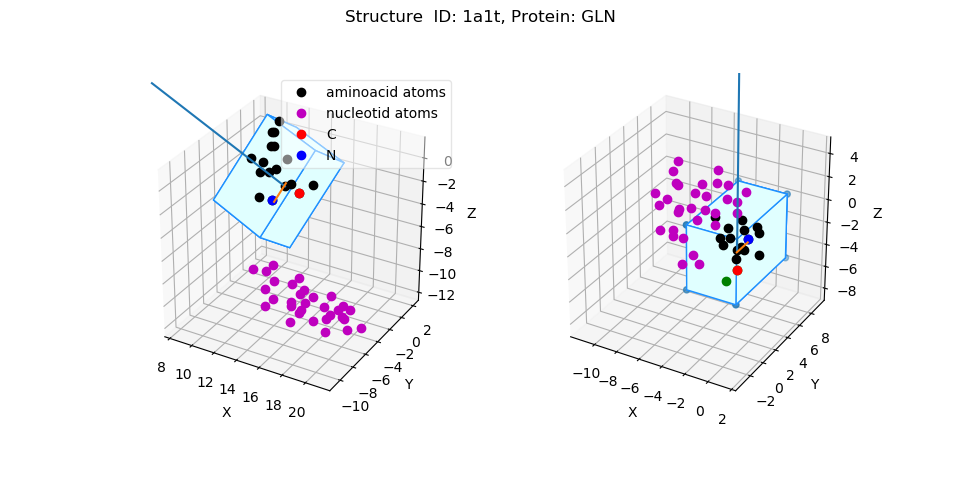

In [5]:
plot_transformation('1a1t', 'GLN', 5.5, 3)

sizes(x, y, z):  7.88268 3.98632 4.43836
angle:  90.19609040536007


<IPython.core.display.Javascript object>


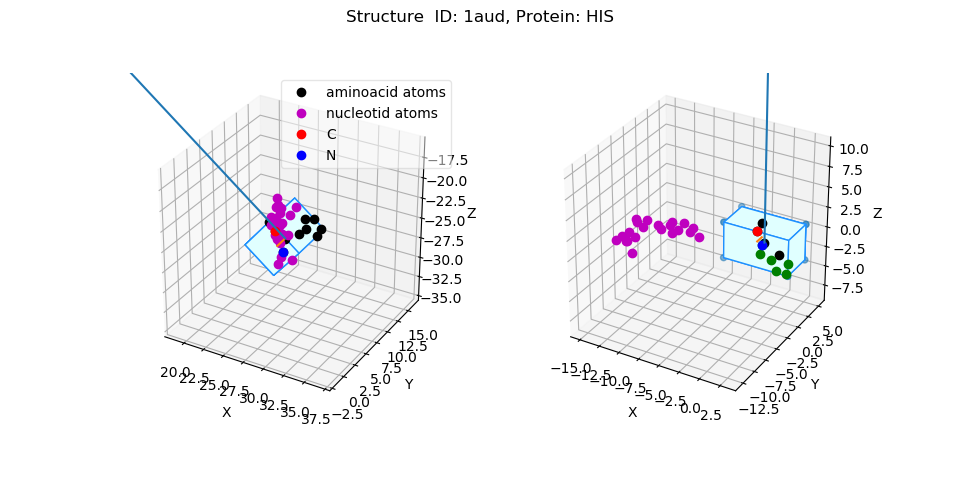

In [11]:
plot_transformation('1aud', 'HIS', 4.5, 3)

sizes(x, y, z):  10.8032 4.38992 4.53014
angle:  87.49285862621993


<IPython.core.display.Javascript object>


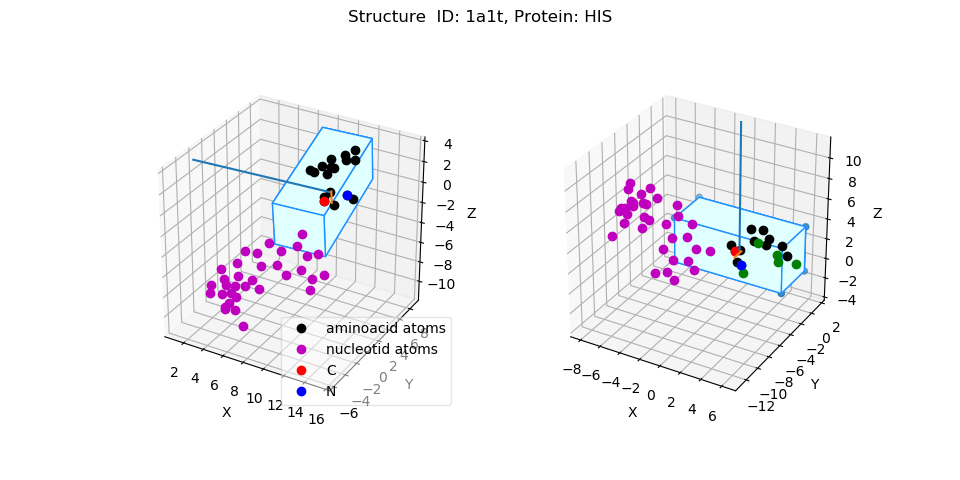

sizes(x, y, z):  10.79442 4.58658 4.48324
angle:  87.4989238342029


<IPython.core.display.Javascript object>


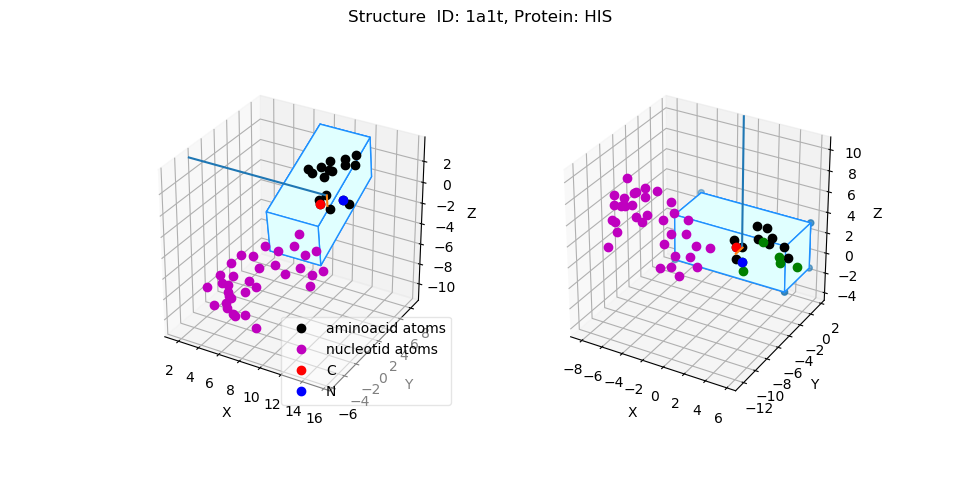

sizes(x, y, z):  10.8074 4.41562 4.5453600000000005
angle:  87.4512764345529


<IPython.core.display.Javascript object>


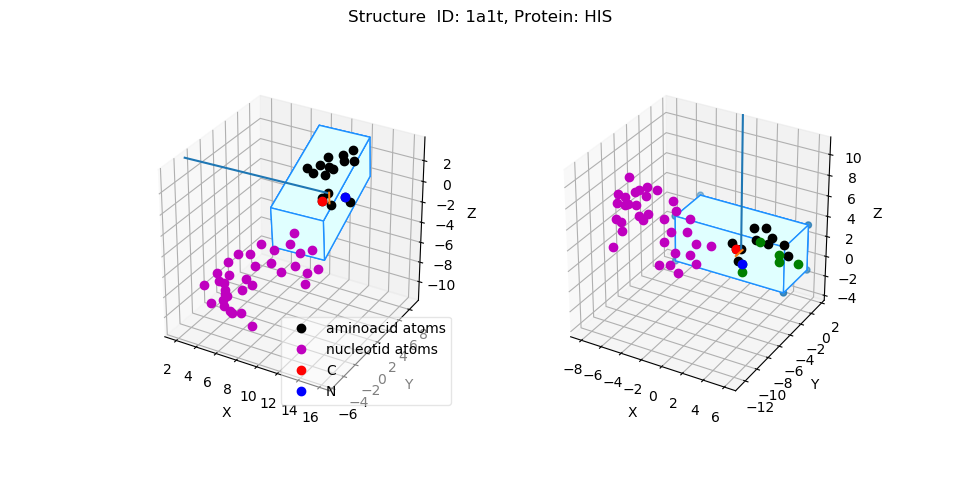

In [9]:
plot_transformation('1a1t', 'HIS', 4.5, 3)